In [1]:
import pandas as pd

In [2]:
atl_sales = pd.read_parquet('output/sales_atl_final.parquet')

names = {}

for investor in ["Amherst", "Invitation", "Progress"]:
    with open (f"output/{investor}_names.txt") as f:
        names[investor.upper()] = f.readlines()[-1].split(", ")

# Change to use addresses
names.update({
    "FCS": ["FCS", "CHARIS ", "MCDONOUGH BLVD"],
    "WESTSIDE": ["WESTSIDE ACQUISITION", "ATL RE HOLDINGS"],
    "ANDP": [
        "ANDP", "ATLANTA NEIGHBORHOOD DEV",
        "ATLANTA NEIGHBORHOOD AND", "ATLANTA NEIGHBORHOOD PARTNERSHIP",
        "ATLANTA NEIGHBORHOOD REDEVELOPMENT"
    ],
})

nonprofits = ["FCS", "WESTSIDE", "ANDP"]

atl_sales = atl_sales[[
    "PARID",
    "Sale Year",
    "Saledt",
    "FAIR MARKET VALUE",
    "DEED TYPE",
    "GRANTOR",
    "GRANTEE",
    "count_sales_yr",
    "GRANTEE_corp_flag",
    "GRANTOR_corp_flag",
    "corp_bought_ind",
    "corp_sold_ind",
    "ind_to_ind",
    "corp_to_corp",
    "neighborhood",
    "Buyer Transactions Fulton",
    "Buyer Scale",
    "Seller Scale",
    "sales_price",
    "price_adj",
    "fmv_adj",
    "sale_diff_adj",
    "sale_diff",
    "mb_flag",
    "geometry"
]]

atl_sales = atl_sales[(atl_sales["corp_bought_ind"] == 1) | (atl_sales["corp_sold_ind"] == 1)]

In [3]:
entity_trans = {
    "FCS": [],
    "WESTSIDE": [],
    "ANDP": [],
    "AMHERST": [],
    "INVITATION": [],
    "PROGRESS": []
}

for name in entity_trans.keys():
    # fmv - sales price; if positive in sale to ind, then ind benefitted
    # entity purchase from ind
    purchases = atl_sales[
        (atl_sales["corp_bought_ind"] == 1) &
        (atl_sales["GRANTEE"].apply(lambda x: any([key in str(x) for key in names[name]])))
    ]
    # entity sale to ind; need to make negative? TODO
    sales = atl_sales[
        (atl_sales["corp_sold_ind"] == 1) &
        (atl_sales["GRANTOR"].apply(lambda x: any([key in str(x) for key in names[name]])))
    ]
    sales["sale_diff_adj"] = sales["sale_diff_adj"].copy() * -1
    total = pd.concat([purchases, sales])

    entity_trans[name] = [purchases, sales, total]

C:\Users\Nick\AppData\Local\Temp\ipykernel_7380\657008062.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales["sale_diff_adj"] = sales["sale_diff_adj"].copy() * -1
C:\Users\Nick\AppData\Local\Temp\ipykernel_7380\657008062.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales["sale_diff_adj"] = sales["sale_diff_adj"].copy() * -1
C:\Users\Nick\AppData\Local\Temp\ipykernel_7380\657008062.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [4]:
# Average sale_diff_adj across each entity for purchases and sales

for entity in entity_trans:
    print(f"Entity: {entity}")
    order = ["purchases", "sales", "total"]
    for i in range(3):
        print(f"{entity_trans[entity][i]['sale_diff_adj'].mean():,.2f} mean loss for {order[i]}; n = {len(entity_trans[entity][i])}")
    print("")

#all_nonprofits = pd.concat(
#    [entity_trans[key][2] for key in entity_trans if key in nonprofits]
#)


Entity: FCS
15,703.06 mean loss for purchases; n = 17
58,927.72 mean loss for sales; n = 68
50,282.79 mean loss for total; n = 85

Entity: WESTSIDE
-46,461.82 mean loss for purchases; n = 7
13,589.97 mean loss for sales; n = 4
-24,624.81 mean loss for total; n = 11

Entity: ANDP
-37,160.93 mean loss for purchases; n = 1
23,333.97 mean loss for sales; n = 15
19,553.04 mean loss for total; n = 16

Entity: AMHERST
-872.55 mean loss for purchases; n = 46
48,537.15 mean loss for sales; n = 11
8,662.65 mean loss for total; n = 57

Entity: INVITATION
-22,460.68 mean loss for purchases; n = 22
11,353.99 mean loss for sales; n = 9
-12,643.52 mean loss for total; n = 31

Entity: PROGRESS
-17,613.89 mean loss for purchases; n = 125
18,579.35 mean loss for sales; n = 144
1,760.93 mean loss for total; n = 269



In [12]:
total_nonprofit_purchase = pd.concat([entity_trans[key][0] for key in nonprofits])
total_profit_purchase = pd.concat([entity_trans[key][0] for key in entity_trans if key not in nonprofits])

total_nonprofit_sale = pd.concat([entity_trans[key][1] for key in nonprofits])
total_profit_sale = pd.concat([entity_trans[key][1] for key in entity_trans if key not in nonprofits])

total_nonprofit = pd.concat([entity_trans[key][2] for key in nonprofits])
total_profit = pd.concat([entity_trans[key][2] for key in entity_trans if key not in nonprofits])

print("Purchases")
print(f"Nonprofit mean loss: {total_nonprofit_purchase['sale_diff_adj'].mean():,.2f}; n = {len(total_nonprofit_purchase)}")
print(f"Profit mean loss: {total_profit_purchase['sale_diff_adj'].mean():,.2f}; n = {len(total_profit_purchase)}")

print("\nSales")
print(f"Nonprofit mean loss: {total_nonprofit_sale['sale_diff_adj'].mean():,.2f}; n = {len(total_nonprofit_sale)}")
print(f"Profit mean loss: {total_profit_sale['sale_diff_adj'].mean():,.2f}; n = {len(total_profit_sale)}")

print("\nTotal")
print(f"Nonprofit mean loss: {total_nonprofit['sale_diff_adj'].mean():,.2f}; n = {len(total_nonprofit)}")
print(f"Profit mean loss: {total_profit['sale_diff_adj'].mean():,.2f}; n = {len(total_profit)}")

Purchases
Nonprofit mean loss: -3,817.67; n = 25
Profit mean loss: -14,176.21; n = 193

Sales
Nonprofit mean loss: 50,706.37; n = 87
Profit mean loss: 20,192.20; n = 164

Total
Nonprofit mean loss: 38,535.83; n = 112
Profit mean loss: 1,612.08; n = 357


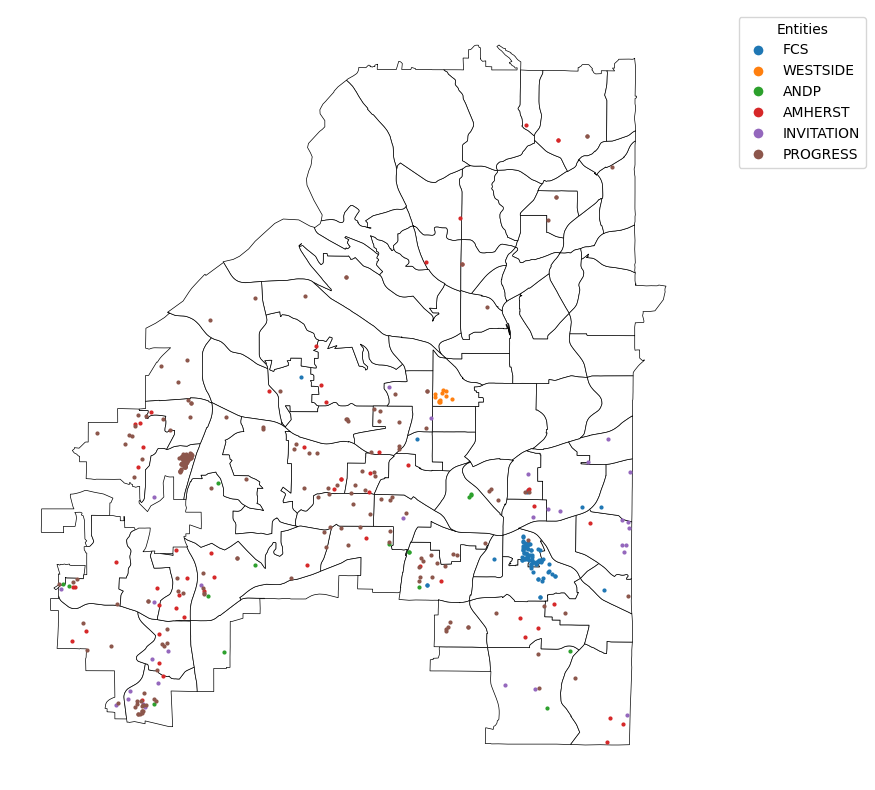

In [9]:
from matplotlib.lines import Line2D
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt

# Plot nbhd map

nbhd_df = gpd.read_file("data/atl_nsa.geojson")
dropped_nbhds = [
    'East Lake, The Villages at East Lake',
    'Edgewood',
    'Candler Park, Druid Hills',
    'Kirkwood',
    'Lake Claire',
    'East Atlanta',
    'Airport'
]

nbhd_df = nbhd_df[~nbhd_df["NEIGHBORHO"].isin(dropped_nbhds)]
ax = nbhd_df.plot(color="white", edgecolor="black", linewidth=0.5, figsize=(10, 10))
ax.set_axis_off()

# Plot on same axis, each entity in a diff color
colors = iter([plt.cm.tab10(i) for i in range(10)])

handles = []
labels = []

for entity in list(entity_trans.keys()):
    temp_df = entity_trans[entity][2].copy()
    temp_df['geometry'] = temp_df['geometry'].apply(wkt.loads).apply(lambda x: x.centroid)
    plot_df = gpd.GeoDataFrame(temp_df)
    curr_color = next(colors)
    plot_handle = plot_df.plot(ax=ax, color=curr_color, markersize=4, marker='o')
    
    # Create a handle for the legend
    handle = Line2D([0], [0], marker='o', color='w', markerfacecolor=curr_color, markersize=8, label=entity)
    handles.append(handle)
    labels.append(entity)
    
plt.legend(handles=handles, title='Entities', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

In [6]:
# Print out names for each entity



In [7]:
# sale_diff = fmv_adj - price_adj

# purchase 50-100 = -50; equity gain to individual from FCS
# sale 50-100 = 50; equity gain to FCS from individual
fcs_names = [
    "FCS",
    "CHARIS ",
    "MCDONOUGH BLVD"
]

westside_names = [
    "WESTSIDE ACQUISITION"
]

andp_names = [
    "ANDP",
    "ATLANTA NEIGHBORHOOD DEV",
    "ATLANTA NEIGHBORHOOD AND"
    "ATLANTA NEIGHBORHOOD PARTNERSHIP",
    "ATLANTA NEIGHBORHOOD REDEVELOPMENT"
]

quest_names = [
    "QUEST"
]

fcs_names = [x.upper() for x in fcs_names]

fcs_bought = atl_sales[atl_sales["GRANTEE"].apply(lambda x: any([key in str(x) for key in fcs_names]))]

fcs_sold = atl_sales[atl_sales["GRANTOR"].apply(lambda x: any([key in str(x) for key in fcs_names]))]
#fcs_bought["sale_diff_adj"] = fcs_bought["sale_diff_adj"] * -1
#fcs_bought["sale_diff"] = fcs_bought["sale_diff"] * -1

fcs_bought_from_ind = fcs_bought[fcs_bought["corp_bought_ind"] == 1]

fcs_sold_to_ind = fcs_sold[fcs_sold["corp_sold_ind"] == 1]
fcs_sold_to_ind["sale_diff"] = -fcs_sold_to_ind["sale_diff"]
fcs_sold_to_ind["sale_diff_adj"] = -fcs_sold_to_ind["sale_diff_adj"]

total_fcs = pd.concat([fcs_bought_from_ind, fcs_sold_to_ind]).drop_duplicates().reset_index(drop=True)
print(len(fcs_bought_from_ind))
print(len(fcs_sold_to_ind))

17
68


<Axes: >

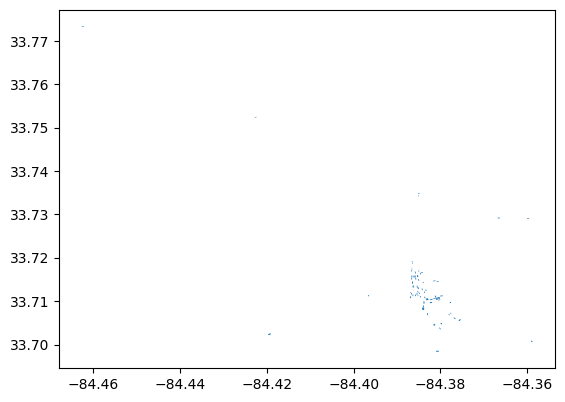

In [8]:
from shapely import wkt
total_fcs['geometry'] = total_fcs['geometry'].apply(wkt.loads)
total_fcs = gpd.GeoDataFrame(total_fcs)
total_fcs.set_geometry("geometry")
total_fcs.plot()